In [1]:
from pathlib import Path
import numpy as np
from hdf5storage import loadmat, savemat
from numpy import random
import numpy as np
import seaborn as sns
import pandas as pd
%matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import gamma, norm
from scipy.stats import multivariate_normal as mvn
from numpy.random import default_rng
from sklearn.linear_model import LinearRegression

Load data

In [2]:
def transform_items_to_z(items):
    alpha = np.empty(items.shape[1])
    beta = np.empty(items.shape[1])
    items_z = np.empty(items.shape)
    for i in range(items.shape[1]):#get useful variables 
        a, loc, scale = gamma.fit(items[:, i], floc=0.0)
        alpha[i] = a
        beta[i] = scale
        u = gamma.cdf(items[:,i], a = a, scale = scale)
        u = np.clip(u, 1e-12, 1-1e-12)
        items_z[:,i] = norm.ppf(u) 
    return alpha, beta,items_z

In [3]:
files = list(Path("results/runA").glob("*.mat"))
#load
rows  = [] 
for f in range(len(files)):
    kn= loadmat(str(files[f]))
    n_con = kn['n_con'] #number of constraints
    n_items = kn['n_items'] #number of items
    n_obj = kn['n_obj'] #number of objectives
    n_selected = kn['n_selected'] #number of selected items#get useful variables 
    r_obj = kn['r_obj']
    r_con = kn['r_con']
    pf = kn['pareto_front_final'] #final paretkedin.com/o front
    pi = kn['pareto_indices_final'] #final pareto indices
    dt = kn['distribution_table'] #distribution table
    items = kn['items'] #item features - objectives and constraints 
    n_run = len(items) # number of runs for a set of parameters 
    shape = np.empty((n_run,n_obj+n_con))
    scale = np.empty((n_run,n_obj+n_con))
    items_z = list()
    r_items = np.empty((n_run,n_obj+n_con,n_obj+n_con))
    for j in range(len(items)):
        items_r = kn['items'][j]
        items_r = items_r+1
        a,b,z = transform_items_to_z(items_r)
        shape[j,:] = a
        scale[j,:] = b
        items_z.append(z)
        r_items[j,:,:]= np.corrcoef(np.transpose(z))
    r_items = np.mean(r_items,axis = 0)
    rows.append([n_obj,-r_obj,r_items[0,1],r_con,r_items[0,-1]])
df = pd.DataFrame(rows,columns = ['n_obj','r_obj','r_items_obj','r_con','r_items_con'])




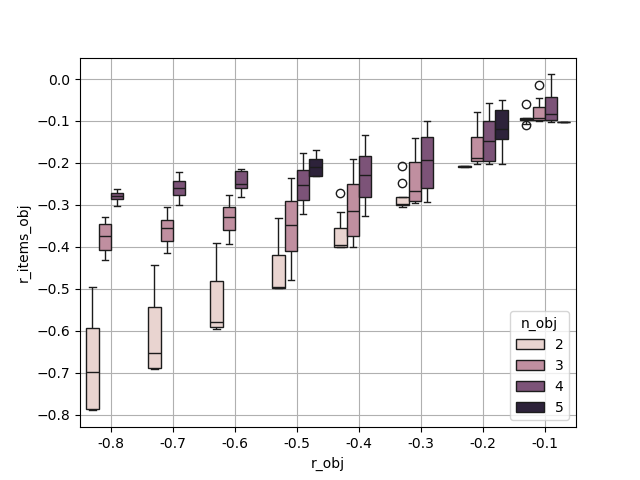

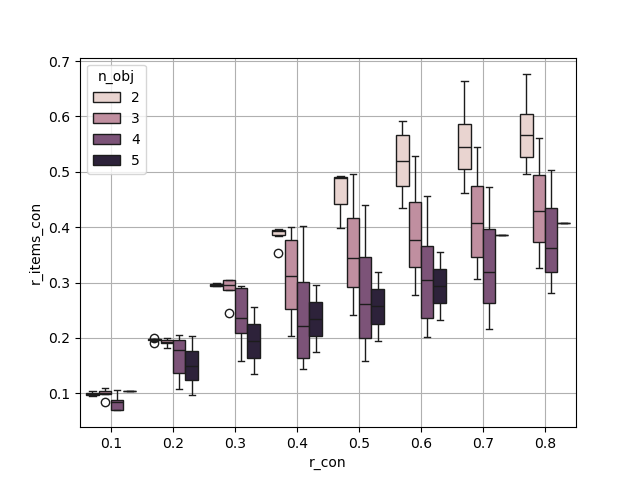

In [4]:
plt.figure()
sns.boxplot(df, x = 'r_obj',y = 'r_items_obj',hue = 'n_obj')
plt.grid()
plt.show()
plt.figure()
sns.boxplot(df,x = 'r_con',y = 'r_items_con', hue = 'n_obj')
plt.grid()
plt.show()

In [5]:
print(kn['rpos'][0])

[[ 1.  -0.8 -0.8 -0.8  0.7]
 [-0.8  1.  -0.8 -0.8  0.7]
 [-0.8 -0.8  1.  -0.8  0.7]
 [-0.8 -0.8 -0.8  1.   0.7]
 [ 0.7  0.7  0.7  0.7  1. ]]


Get useful variables 

In [6]:
n_con = kn['n_con'] #number of constraints
n_items = kn['n_items'] #number of items
n_obj = kn['n_obj'] #number of objectives
n_selected = kn['n_selected'] #number of selected items#get useful variables 
pf = kn['pareto_front_final'] #final paretkedin.com/o front
pi = kn['pareto_indices_final'] #final pareto indices
dt = kn['distribution_table'] #distribution table
items = kn['items'] #item features - objectives and constraints 
n_run = len(items) # number of runs for a set of parameters 


This function transforms any set of items to the normal space.  This is going to be used many times  

For each of the runs, transform the items to the normal space as items_z and compute the correlation matrix between 

In [7]:
shape = np.empty((n_run,n_obj+n_con))
scale = np.empty((n_run,n_obj+n_con))
items_z = list()
r_items = np.empty((n_run,n_obj+n_con,n_obj+n_con))
for j in range(len(items)):
    items_r = kn['items'][j]
    items_r = items_r+1
    a,b,z = transform_items_to_z(items_r)
    shape[j,:] = a
    scale[j,:] = b
    items_z.append(z)
    r_items[j,:,:]= np.corrcoef(np.transpose(z))

<Axes: >

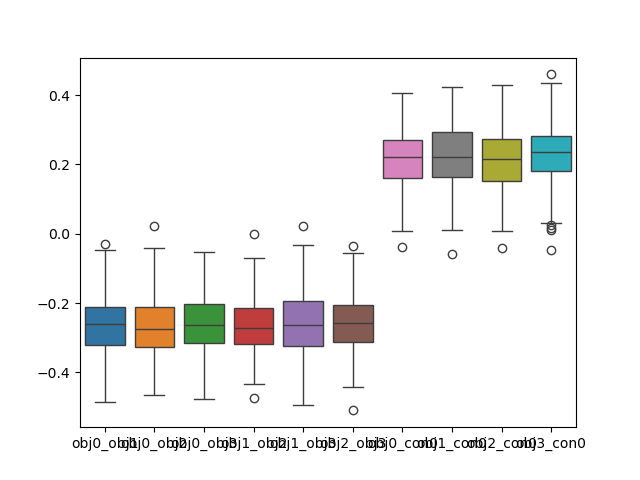

In [8]:
import pandas as pd
corrdf = pd.DataFrame()
for j in range(n_obj):
    for k in range(j+1,n_obj):
        corrdf[f"obj{j}_obj{k}"] = r_items[:,j,k]
for j in range(n_obj):
        corrdf[f"obj{j}_con0"] = r_items[:,j,n_obj]
plt.figure()
sns.boxplot(corrdf)       

In [9]:
rng = default_rng(seed = 1111)
XX_z_list = []
XX_list = []
for j in range(len(pi)):
    px = pi[j]
    XX = np.empty((px.shape[0],n_selected,n_obj+n_con))
    XX_z = np.empty((px.shape[0],n_selected,n_obj+n_con))
    for k in range(px.shape[0]): 
        qx = rng.permutation(px[k,:])
        XX_z[k,:,:] = items_z[j][qx,:]
        XX[k,:,:] = items[j][qx,:]
#    YY = np.cumsum(XX,axis = 1)
    XX_z_list.append(XX_z)
    XX_list.append(XX)

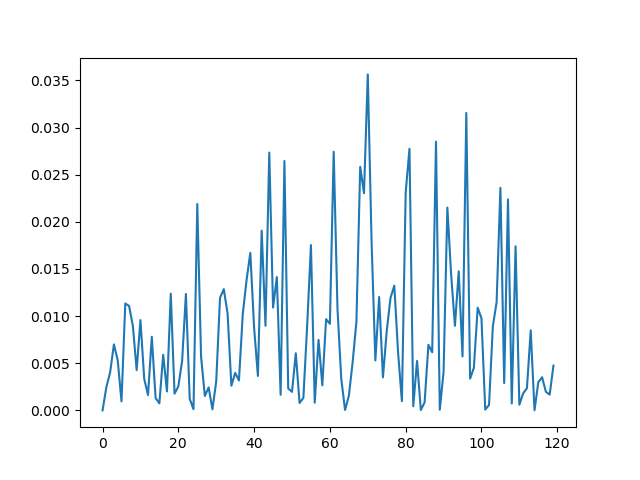

In [10]:
def base_rate_model(items_z,XX_0):
    mean0 = np.mean(XX_0,axis = 0)
    Sigma0 = np.cov(XX_0.T) #python is stupid
    mvn0 = mvn(mean=mean0, cov=Sigma0)
    x_candidates = items_z
    probabilities = mvn0.pdf(x_candidates)
    probabilities = (probabilities+1e-12)/sum(probabilities+1e-12)
    return probabilities
probabilities = base_rate_model(items_z[100],np.vstack(XX_z_list)[:,0,:])
plt.figure()
plt.plot(probabilities)


Build xgboost estimates of conditional probability 

In [11]:
def make_context_target_pairs_per_time(Z):
    K, N, d = Z.shape
    out: List[Optional[Tuple[np.ndarray, np.ndarray]]] = [None] * (N + 1)
    for t in range(2, N + 1):
        X_t = Z[:, :t-1, :].reshape(K, (t-1)*d).astype(np.float32)
        Y_t = Z[:, t-1, :].astype(np.float32)
        out[t] = (X_t, Y_t)
    return out

In [12]:
def eval_knapsack(knapsack,pf_actual,n_obj,scale,shape):
    pf_predicted = np.sum(knapsack, axis=0)
    std_dev = np.sqrt(shape)*scale
    count = 0 
    pfdif = np.zeros(pf_actual.shape[0])
    for j in range(pf_actual.shape[0]):
        if np.any(pf_predicted[0:n_obj] > pf_actual[j,0:n_obj]):
            count = count + 1
        pfdif[j] = np.linalg.norm(pf_predicted[0:n_obj]/std_dev[0:n_obj] - pf_actual[j,0:n_obj]/std_dev[0:n_obj])
    pf_difference = np.min(pfdif) 
    domination_score = 1-count/pf_actual.shape[0]
    return domination_score, pf_difference


In [13]:
pf_difference = np.zeros(40)
domination_score = np.zeros(40)
for kk in range(40):
    k = kk+160
    probabilities = base_rate_model(items_z[k],np.vstack(XX_z_list[0:160])[:,0,:])
    knapsack_indices = np.zeros(n_selected,dtype=int)
    knapsack = np.zeros((n_selected,(n_obj+n_con)))
    first_choice = np.argmax(probabilities)
    first_item = items_z[k][first_choice,:]
    x_indices = np.setdiff1d(np.arange(n_items),knapsack_indices)
    y_prev = first_item 
    knapsack[0,:] = items[k][first_choice,:]
    knapsack_indices[0] = first_choice
    for n in range(1,n_selected):
        x_indices = np.setdiff1d(np.arange(n_items),knapsack_indices[0:n])
        x_candidates = items_z[k][x_indices,:]
        densities = conditional_density_given_Y_and_t(x_candidates, y_prev, params_yz_time, t=n)
        probabilities = densities/sum(densities)
        next_choice = np.argmax(probabilities)
        next_index = x_indices[next_choice]
        next_item = items_z[k][next_index,:]
        knapsack[n,:] = items[k][next_index,:]
        knapsack_indices[n] = next_index
        y_prev = y_prev + next_item
  
    pf_predicted = np.sum(knapsack, axis=0)
    pf_actual = pf[k]
    count = 0 
    domination_score[kk], pf_difference[kk] = eval_knapsack(knapsack,pf_actual,n_obj,kn['scale'],kn['shape'])


NameError: name 'conditional_density_given_Y_and_t' is not defined

In [ ]:
print(np.mean(domination_score))
print(np.mean(pf_difference))
print(np.sqrt(kn['shape'])*kn['scale'])

0.13055741724672068
3.660454445476128
[3.         3.46410162 6.         2.82842712 2.82842712]
